## Setup the environment

### Clone repository

In [1]:
%env EXERCISE_NAME=04-ape-and-fine-tuning
%env REPO_NAME=llmops-workshop

env: EXERCISE_NAME=04-ape-and-fine-tuning
env: REPO_NAME=llmops-workshop


In [2]:
! echo "Cloning the repository...${REPO_NAME}"

Cloning the repository...llmops-workshop


In [ ]:
# ! git clone https://github.com/getindata/$REPO_NAME.git

In [3]:
def is_colab():
    try:
        import google.colab  # noqa: F401

        return True
    except ImportError:
        return False

### Prepare environment variables, Python modules search path and install dependencies

In [4]:
import os
if is_colab():
    os.environ["EXERCISE_ROOT"] = f"/content/${os.environ['REPO_NAME']}/exercises"
    os.environ["EXERCISE_RUN"] = "colab"
else:
    os.environ["EXERCISE_ROOT"] = f"{os.getcwd()}/exercises"
    os.environ["EXERCISE_RUN"] = "local"

os.environ['EXERCISE_DIR'] = f"{os.environ['EXERCISE_ROOT']}/{os.environ['EXERCISE_NAME']}"
get_ipython().run_line_magic("run", f"{os.environ['EXERCISE_ROOT']}/shared/setup/__setup_{os.environ['EXERCISE_RUN']}.ipynb")

/Users/mwiewior/research/git/llmops-workshop/exercises/04-ape-and-fine-tuning


In [5]:
import sys

sys.path.append(f"{os.environ['EXERCISE_DIR']}/src")

In [6]:
%pip install -r {os.environ['EXERCISE_DIR']}/requirements.txt

  Cloning https://github.com/mwiewior/mlflow.git (to revision dspy-bug) to /private/var/folders/l3/8404fxz55gvdfszw4zf7ptp40000gn/T/pip-req-build-8stezxg4
  Running command git clone --filter=blob:none --quiet https://github.com/mwiewior/mlflow.git /private/var/folders/l3/8404fxz55gvdfszw4zf7ptp40000gn/T/pip-req-build-8stezxg4
  Running command git checkout -b dspy-bug --track origin/dspy-bug
  Switched to a new branch 'dspy-bug'
  branch 'dspy-bug' set up to track 'origin/dspy-bug'.
  Resolved https://github.com/mwiewior/mlflow.git to commit 2322a6fe88c5c2eb39b64232a87c0c34c46d53e6
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Users/mwiewior/research/git/llmops-workshop/.venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the ker

### Langfuse connection

In [7]:
import base64
import os

os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-005b77e6-7931-475e-85bd-46ec47e5201d"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-8b31ee9a-2c89-4c47-a37a-ec084d735170"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"
os.environ["LANGFUSE_AUTH"] = base64.b64encode(
    f"{os.environ['LANGFUSE_PUBLIC_KEY']}:{os.environ['LANGFUSE_SECRET_KEY']}".encode()
).decode()
os.environ["OTEL_EXPORTER_OTLP_TRACES_ENDPOINT"] = (
    f"{os.environ['LANGFUSE_HOST']}/api/public/otel/v1/traces"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_HEADERS"] = (
    f"Authorization=Basic {os.environ['LANGFUSE_AUTH']}"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_PROTOCOL"] = "http/protobuf"

In [8]:
from langfuse import Langfuse

langfuse = Langfuse()

## Data preparation

In [ ]:
import polars as pl

df = pl.read_csv(f"{os.environ['EXERCISE_DIR']}/data/input/sms_phishing.csv")
datasets = []
for r in df.iter_rows(named=True):
    datasets.append({"input": r["TEXT"], "expected_output": r["LABEL"].lower()})

In [ ]:
TRAIN_PCT = 0.9666
VAL_PCT = 0.0167
TEST_PCT = 0.0167
train_ds = datasets[: int(len(datasets) * TRAIN_PCT)]
val_ds = datasets[
    int(len(datasets) * TRAIN_PCT) : int(len(datasets) * (TRAIN_PCT + VAL_PCT))
]
test_ds = datasets[int(len(datasets) * (TRAIN_PCT + VAL_PCT)) :]
len(train_ds), len(val_ds), len(test_ds)

### Create Langfuse datasets


In [ ]:
def create_dataset(name: str, ds: list):
    langfuse.create_dataset(name=name)
    for item in ds:
        langfuse.create_dataset_item(
            dataset_name=name,
            input=item["input"],
            expected_output=item["expected_output"],
        )

In [ ]:
create_dataset("sms_phishing_train", train_ds)
create_dataset("sms_phishing_val", val_ds)
create_dataset("sms_phishing_test", test_ds)

## Register the prompt

In [9]:
langfuse.create_prompt(
    name="sms-classifier",
    type="text",
    prompt=" Given an SMS text, classify whether it is 'ham', 'spam', or 'smishing'. Output only the predicted label.",
    labels=["sandbox"],
    tags=["sms", "dspy", "classifier"],
)

## Create a SMSClassifier module with DSPy

### Configure which LLM to use (Ollama Gemma3)
DSpy uses [LiteLLM](https://www.litellm.ai/) to abstract the LLM provider.

In [10]:
import dspy

MODEL = "gemma3:1b"

lm = dspy.LM(f"ollama/{MODEL}", cache=False, num_retries=5)
dspy.settings.configure(lm=lm, track_usage=False)

### Configuring DSPy traces with OpenTelemetry using MLflow client

In [11]:
import mlflow

mlflow.dspy.autolog()

In [12]:
import logging

logger = logging.getLogger("mlflow")
logger.setLevel(logging.INFO)

In [ ]:
lm("Hello world!")

### Create a DSPy
1. We first create a Signature that defines the schema of the input and output of the module and well as the default instructions.
2. Then we create a Module that combines the Signature with the prompting strategy, such Chain of Thought, ReAct, .


In [13]:
from typing import Literal

import dspy


class SMSClassifierSignature(dspy.Signature):
    """
    Given an SMS text, predict whether it is ham, spam, or smishing.
    Output only the predicted label.
    """

    sms_text: str = dspy.InputField()
    category: Literal["ham", "spam", "smishing"] = dspy.OutputField()


class SMSClassifier(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(SMSClassifierSignature)

    @mlflow.trace
    def forward(self, sms_text):
        return self.generate_answer(sms_text=sms_text)

In [15]:
sms_classifier = SMSClassifier()

In [ ]:
sms_classifier(sms_text="Sorry i missed your call. Can you please call back.")

In [ ]:
sms_classifier(
    sms_text="We have received a request from you for purchasing Paytm Payments Bank FASTag. Total amount to be paid is Rs 250/- (Tag Cost Rs. 100 Security Deposit Rs. 0, Threshold -Rs. 150). In case of any queries, please contact us at https://m.paytm.me/fastag-help"
)

In [ ]:
# wrong should be categorized as spam
sms_classifier(
    sms_text="Rental  Helpline  9999991155 1000-100, 000 sq.ft. In Noida & Gr.Noida  OFFICE & INDUSTRIAL Use Goldenberg estates pvt.ltd. sandeep@goldenberg.in 999 999 115"
)

In [ ]:
lm.inspect_history(n=1)

## Run evaluation on the test dataset

### Pull the models

In [ ]:
%%bash
models=("gemma3:1b" "qwen2.5:1.5b" "qwen2.5:14b" "gemma3:12b")
for model in "${models[@]}"; do
echo "Pulling model: $model"
ollama pull "$model"
done


### Prepare the test dataset

In [17]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [18]:
import uuid
from evaluation_helpers import plot_metrics, run_evaluation

run_id = uuid.uuid1()

models = ["gemma3:1b", "qwen2.5:1.5b", "qwen2.5:14b", "gemma3:12b"]


# full run (if you would like to run all models - remember to pull them first)
# models = [
#         "smollm2:360m", "smollm2:1.7b",
#         "qwen2.5:0.5b", "qwen2.5:1.5b",
#         "gemma3:1b", "gemma3:4b", "granite3.2:2b",
#         "gemma3:12b", "qwen2.5:14b", "phi4:14b"
# ]

classes = ["ham", "spam", "smishing"]

run_evaluation(models, sms_classifier, test_ds, classes, run_id, prefix="baseline")

Average Metric: 78.00 / 100 (78.0%): 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


In [19]:
from evaluation_helpers import get_all_metric

metrics_baseline = get_all_metric(models, run_id, classes, prefix="baseline")

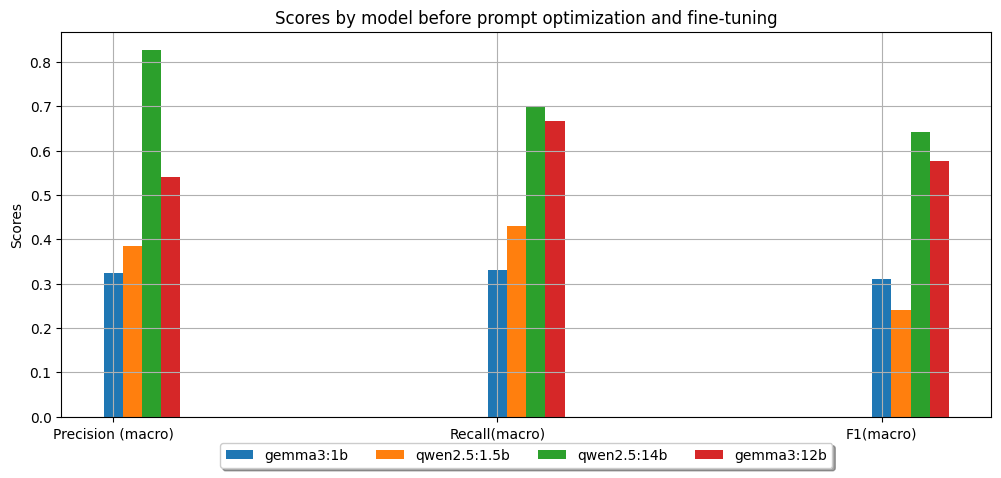

In [21]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before prompt optimization and fine-tuning",
)